## 1. Data Preparation

- Read feature database 

In [76]:
import pandas as pd

feature_mart = pd.read_csv("C:\\Users\\zhao\\Desktop\\final\\back_testing\\NFLX_Feature_Mart.csv")
feature_mart.set_index("Date", inplace=True)
feature_mart.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Daily_Return,SP500,T10Y3M,...,RSI_14,OBV,Close_EMA_50,ROC_10,Momentum_10,SMA_50,SMA_200,VIX_Close,Sentiment,Interest
Date,,,,,,,,,,,,,,,,,,,,,
2020/11/13,486.769989,488.940002,477.799988,482.839996,482.839996,3002700,-3.929993,-0.008106,3585.15,0.80,...,48.325272,-22745700,498.471669,1.492413,-21.369995,502.470998,443.67860,23.100000,0.000000,46
2020/11/16,480.000000,485.579987,477.299988,479.100006,479.100006,3953600,-3.739990,-0.007776,3626.91,0.82,...,47.007979,-26699300,497.711996,-1.036931,3.360016,501.461798,444.44410,22.450001,0.046209,48
2020/11/17,480.119995,487.510010,478.850006,480.630005,480.630005,3698100,1.529999,0.003188,3609.53,0.78,...,48.280306,-23001200,497.042114,-1.352571,-3.489990,499.943398,445.09925,22.709999,-0.037538,45
2020/11/18,481.950012,488.609985,477.720001,481.790008,481.790008,3629200,1.160004,0.002411,3567.79,0.79,...,42.337668,-19372000,496.443992,-3.050609,-5.429993,498.522398,445.74240,23.840000,-0.140219,44
2020/11/19,482.000000,487.799988,480.470001,484.670013,484.670013,2254700,2.880005,0.005960,3581.87,0.79,...,53.698958,-17117300,495.982267,-5.662176,-12.279999,497.700798,446.45135,23.110001,0.000000,42


- Confirm data range


In [77]:
start_date = feature_mart.index.min()
end_date = feature_mart.index.max()
print(f"Data range: {start_date} to {end_date}")

Data range: 2020/11/13 to 2024/8/9


- Split training set and testing set

In [78]:
feature_mart.index = pd.to_datetime(feature_mart.index)
feature_mart = feature_mart[feature_mart.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2024-03-30")
df_train = feature_mart[feature_mart.index <= split_date]
df_test = feature_mart[feature_mart.index > split_date]

# Obtain the date range for the training and testing sets
train_date_range = (df_train.index.min().strftime("%Y-%m-%d"), df_train.index.max().strftime("%Y-%m-%d"))
test_date_range = (df_test.index.min().strftime("%Y-%m-%d"), df_test.index.max().strftime("%Y-%m-%d"))

print(f"Train set date range: {train_date_range[0]} to {train_date_range[1]}")
print(f"Test set date range: {test_date_range[0]} to {test_date_range[1]}")

Train set date range: 2022-01-03 to 2024-03-28
Test set date range: 2024-04-02 to 2024-08-30


- Construct feature matrix and target value for training set and testing set

In [79]:
x_train = df_train.loc[:, df_train.columns != "Close"][:-1]
x_train = x_train.drop(["Open", "High", "Low", "Adj Close"], axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

x_test = df_test.loc[:, df_test.columns != "Close"][:-1]
x_test = x_test.drop(["Open", "High", "Low", "Adj Close"], axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

- Feature standardization processing

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

- Prepare the merge result function

In [81]:
def merge_results(y_test, y_pred):
    y_test = y_test.to_frame(name="Actual Price")
    y_test = y_test.rename_axis("Date")
    y_pred = pd.Series(y_pred, index=y_test.index)
    y_pred = y_pred.to_frame(name="Predicted Price")
    y_pred = y_pred.rename_axis("Date")

    results = y_test.merge(y_pred, left_index=True, right_index=True, how="inner")

    return results

- Prepare the plot model predictions function

In [82]:
import matplotlib.pyplot as plt

def plot_model_predictions(df, actual_col, predicted_col, model_name, RMSE, figsize=(15, 5)):

    plt.figure(figsize=figsize)
    plt.plot(
        df[actual_col], 
        label="Actual Close Price", 
        linestyle="solid", 
        color="#1f77b4", 
        linewidth=2
    )
    plt.plot(
        df[predicted_col], 
        label="Predicted Close Price", 
        linestyle="dashed", 
        color="#d62728", 
        linewidth=2
    )
    plt.title(f"{model_name} Prediction: Netflix Stock Price", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12, fontweight='bold')
    plt.ylabel("Close Price", fontsize=12, fontweight='bold')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend(
        loc="upper left",
        title=f"RMSE = {RMSE:.2f}",
        title_fontsize=12,
        fontsize=10,
        frameon=True,
        shadow=True,
        fancybox=True,
        edgecolor="gray",
        facecolor="white",
        borderpad=1
    )
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

## 2. Model Training, Hyperparameter Optimization and RMSE Comparison

## Ridge Regression

In [83]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import math
import numpy as np

# Define candidate alpha values
alphas = np.linspace(0.01, 100, 500)

# Automatically select the best alpha using RidgeCV
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(x_train_scaled, y_train)

# Optimal alpha
best_alpha = ridge_cv.alpha_
print(f"Ridge Best alpha: {best_alpha:.2f}")

# Predictions for training and testing setsPredictions for training and testing sets
y_pred_train_ridge = ridge_cv.predict(x_train_scaled)
y_pred_test_ridge = ridge_cv.predict(x_test_scaled)

# Calculate RMSE
RMSE_train_ridge = math.sqrt(mean_squared_error(y_train, y_pred_train_ridge))
RMSE_test_ridge = math.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
print(f"RMSE on training set: {RMSE_train_ridge:.2f}")
print(f"RMSE on test set: {RMSE_test_ridge:.2f}")

Ridge Best alpha: 42.69
RMSE on training set: 19.33
RMSE on test set: 24.15


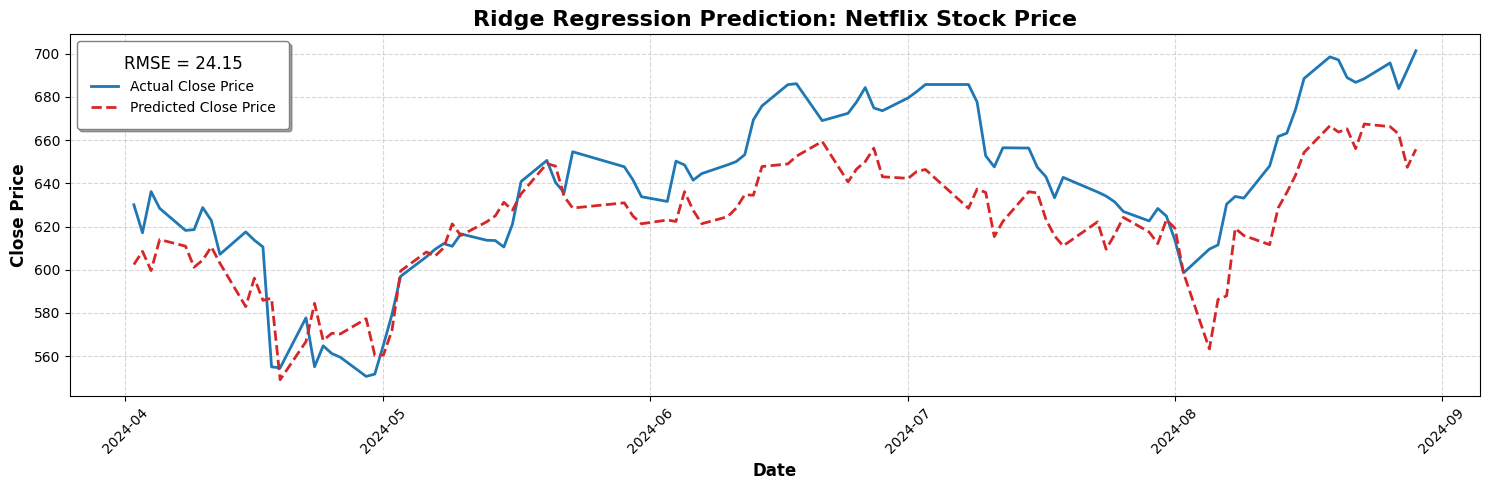

In [84]:
ridge_prediction_df = merge_results(y_test, y_pred_test_ridge)
plot_model_predictions(
    df=ridge_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Ridge Regression", 
    RMSE=RMSE_test_ridge
)

## LASSO

In [85]:
from sklearn.linear_model import LassoCV

# Define candidate alpha values
alphas = np.logspace(-3, 2, 500)

# Automatically select the best alpha using LassoCV
lasso_cv = LassoCV(alphas=alphas,max_iter=3000, cv=5, random_state=42)
lasso_cv.fit(x_train_scaled, y_train)

# Optimal alpha
best_alpha = lasso_cv.alpha_
print(f"Lasso Best alpha: {best_alpha:.2f}")

# Predictions for training and testing sets
y_pred_train_lasso = lasso_cv.predict(x_train_scaled)
y_pred_test_lasso = lasso_cv.predict(x_test_scaled)

# Calculate RMSE
RMSE_train_lasso = math.sqrt(mean_squared_error(y_train, y_pred_train_lasso))
RMSE_test_lasso = math.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
print(f"RMSE on training set: {RMSE_train_lasso:.2f}")
print(f"RMSE on test set: {RMSE_test_lasso:.2f}")

Lasso Best alpha: 0.52
RMSE on training set: 17.21
RMSE on test set: 14.32


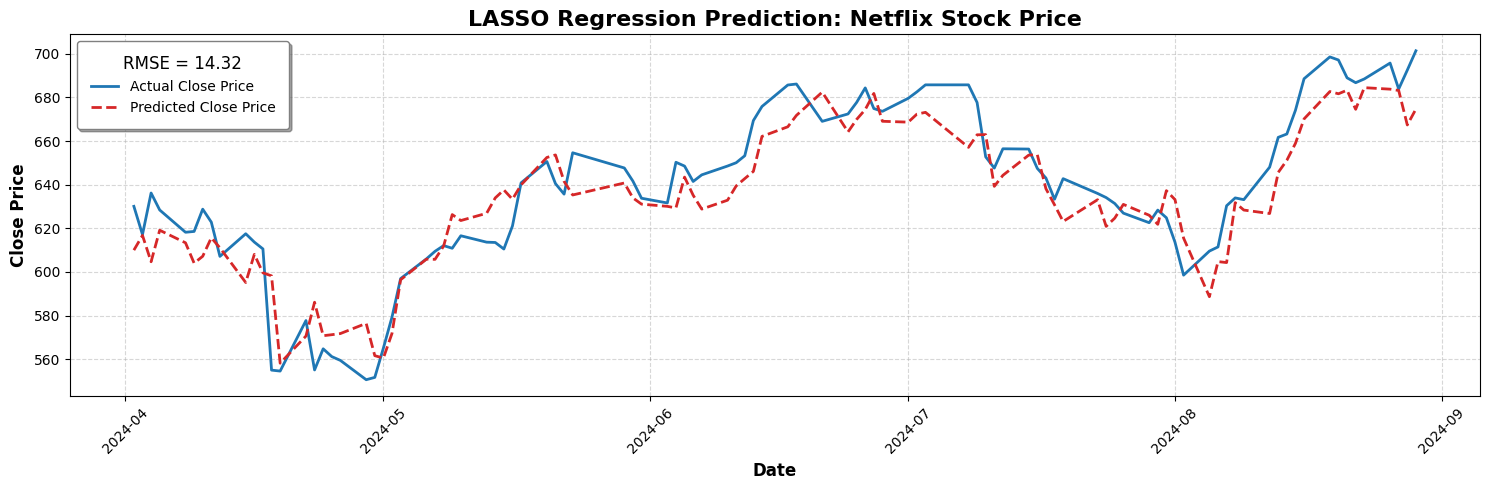

In [86]:
lasso_prediction_df = merge_results(y_test, y_pred_test_lasso)
plot_model_predictions(
    df=lasso_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="LASSO Regression", 
    RMSE=RMSE_test_lasso
)

## LARS

In [87]:
from sklearn.linear_model import LarsCV

# Using LarsCV to automatically select the best alpha
lars_cv = LarsCV(cv=5, max_iter=500)
lars_cv.fit(x_train_scaled, y_train)

# Optimal alpha
best_alpha = lars_cv.alpha_
print(f"LARS Best alpha: {best_alpha:.2f}")

# Predictions for training and testing sets
y_pred_train_lars = lars_cv.predict(x_train_scaled)
y_pred_test_lars = lars_cv.predict(x_test_scaled)

# Calculate RMSE
RMSE_train_lars = math.sqrt(mean_squared_error(y_train, y_pred_train_lars))
RMSE_test_lars = math.sqrt(mean_squared_error(y_test, y_pred_test_lars))
print(f"RMSE on training set: {RMSE_train_lars:.2f}")
print(f"RMSE on test set: {RMSE_test_lars:.2f}")

LARS Best alpha: 10.81
RMSE on training set: 28.45
RMSE on test set: 76.20


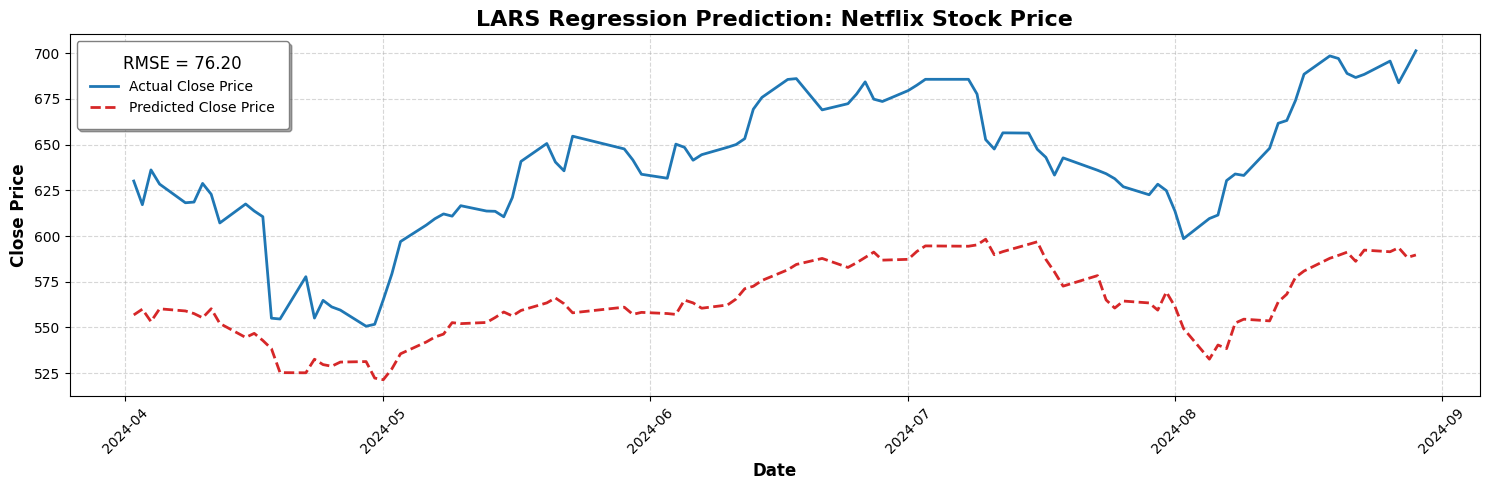

In [88]:
lars_prediction_df = merge_results(y_test, y_pred_test_lars)
plot_model_predictions(
    df=lars_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="LARS Regression", 
    RMSE=RMSE_test_lars
)

## Elastic Net

In [89]:
from sklearn.linear_model import ElasticNetCV

alphas = np.logspace(-3, 2, 500)
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
    alphas=alphas,
    cv=5,
    random_state=33,
    max_iter=10000
)
elastic_net.fit(x_train_scaled, y_train)

print(f"Optimal L1 ratio: {elastic_net.l1_ratio_}")
print(f"Optimal alpha: {elastic_net.alpha_:.2f}")

y_pred_train_en = elastic_net.predict(x_train_scaled)
y_pred_test_en = elastic_net.predict(x_test_scaled)

RMSE_train_en = math.sqrt(mean_squared_error(y_train, y_pred_train_en))
RMSE_test_en = math.sqrt(mean_squared_error(y_test, y_pred_test_en))

print(f"ElasticNet RMSE on training set: {RMSE_train_en:.2f}")
print(f"ElasticNet RMSE on test set: {RMSE_test_en:.2f}")

Optimal L1 ratio: 0.9
Optimal alpha: 0.51
ElasticNet RMSE on training set: 19.09
ElasticNet RMSE on test set: 24.10


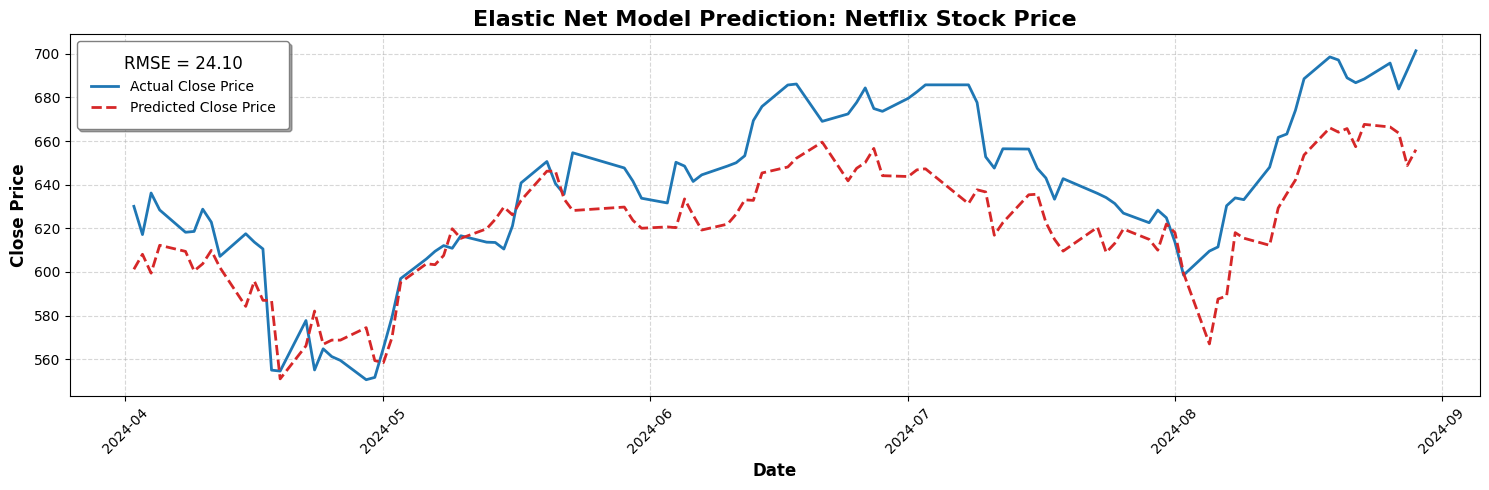

In [90]:
en_prediction_df = merge_results(y_test, y_pred_test_en)
plot_model_predictions(
    df=en_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Elastic Net Model", 
    RMSE=RMSE_test_en
)

## Random Forest

In [91]:
from sklearn.ensemble import RandomForestRegressor
from itertools import product

# Define the hyperparameters to tune
n_estimators_list = [20, 50, 100, 200]
max_depth_list = [2, 4, 6, 8]
max_features_list = [5, 10, 15, 20]
min_samples_leaf_list = [1, 2, 4]

# Prepare a list to store results
results = []

# Loop through all combinations of hyperparameters
for n_estimators, max_depth, max_features, min_samples_leaf in product(n_estimators_list, 
                                                                        max_depth_list, 
                                                                        max_features_list, 
                                                                        min_samples_leaf_list):
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=max_depth, 
                                max_features=max_features,
                                min_samples_leaf=min_samples_leaf, 
                                random_state=33)
    
    # Initialize RandomForestRegressor
    rf.fit(x_train, y_train)
    y_pred_rf = rf.predict(x_test)
    RMSE_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
    results.append((n_estimators, max_depth, max_features, min_samples_leaf, RMSE_rf))

In [92]:
best_params = min(results, key=lambda x: x[4])

best_rf_model = RandomForestRegressor(n_estimators=best_params[0], 
                                      max_depth=best_params[1], 
                                      max_features=best_params[2], 
                                      min_samples_leaf=best_params[3], 
                                      random_state=42)
best_rf_model.fit(x_train, y_train)

y_pred_train_rf = best_rf_model.predict(x_train)
y_pred_test_rf = best_rf_model.predict(x_test)

RMSE_train_rf = math.sqrt(mean_squared_error(y_train, y_pred_train_rf))
RMSE_test_rf = math.sqrt(mean_squared_error(y_test, y_pred_test_rf))
print("Final Random Forest Model:")
print(f"RMSE on training set: {RMSE_train_rf:.2f}")
print(f"RMSE on test set: {RMSE_test_rf:.2f}")

Final Random Forest Model:
RMSE on training set: 9.57
RMSE on test set: 51.52


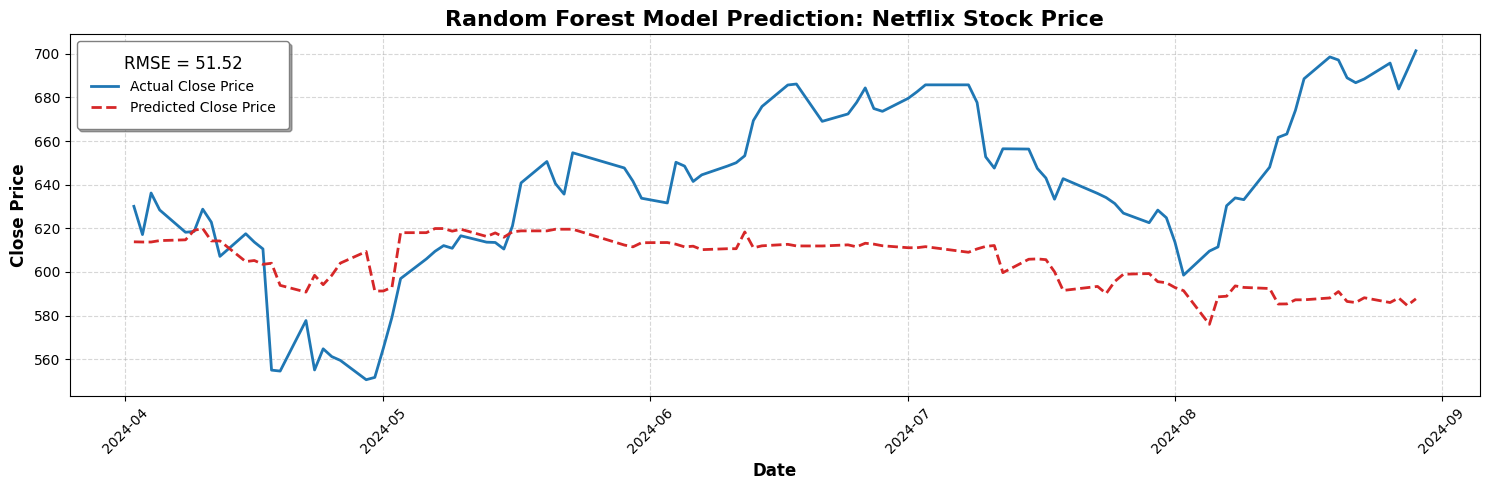

In [93]:
rf_prediction_df = merge_results(y_test, y_pred_test_rf)
plot_model_predictions(
    df=rf_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Random Forest Model", 
    RMSE=RMSE_test_rf
)

## XGboost

In [94]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
import math

optuna.logging.set_verbosity(optuna.logging.WARNING)

train_dmatrix = xgb.DMatrix(x_train, label=y_train)
test_dmatrix = xgb.DMatrix(x_test, label=y_test)

def optimize_xgboost(trial):
    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10, log=True),
    }
    booster = xgb.train(
        params=params,
        dtrain=train_dmatrix,
        num_boost_round=1000,
        evals=[(test_dmatrix, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    y_pred = booster.predict(test_dmatrix)
    RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
    
    return RMSE

study = optuna.create_study(direction="minimize")
study.optimize(optimize_xgboost, n_trials=100)
best_params = study.best_params

In [95]:
final_model = xgb.train(
    params=best_params,
    dtrain=train_dmatrix,
    num_boost_round=1000,
    evals=[(test_dmatrix, "validation")],
    early_stopping_rounds=50,
    verbose_eval=False,
)

y_pred_train_xg = final_model.predict(train_dmatrix)
y_pred_test_xg = final_model.predict(test_dmatrix)

RMSE_train_xg = math.sqrt(mean_squared_error(y_train, y_pred_train_xg))
RMSE_test_xg = math.sqrt(mean_squared_error(y_test, y_pred_test_xg))
print("Final XGboost Model:")
print(f"RMSE on training set: {RMSE_train_xg:.2f}")
print(f"RMSE on test set: {RMSE_test_xg:.2f}")

Final XGboost Model:
RMSE on training set: 4.46
RMSE on test set: 39.53


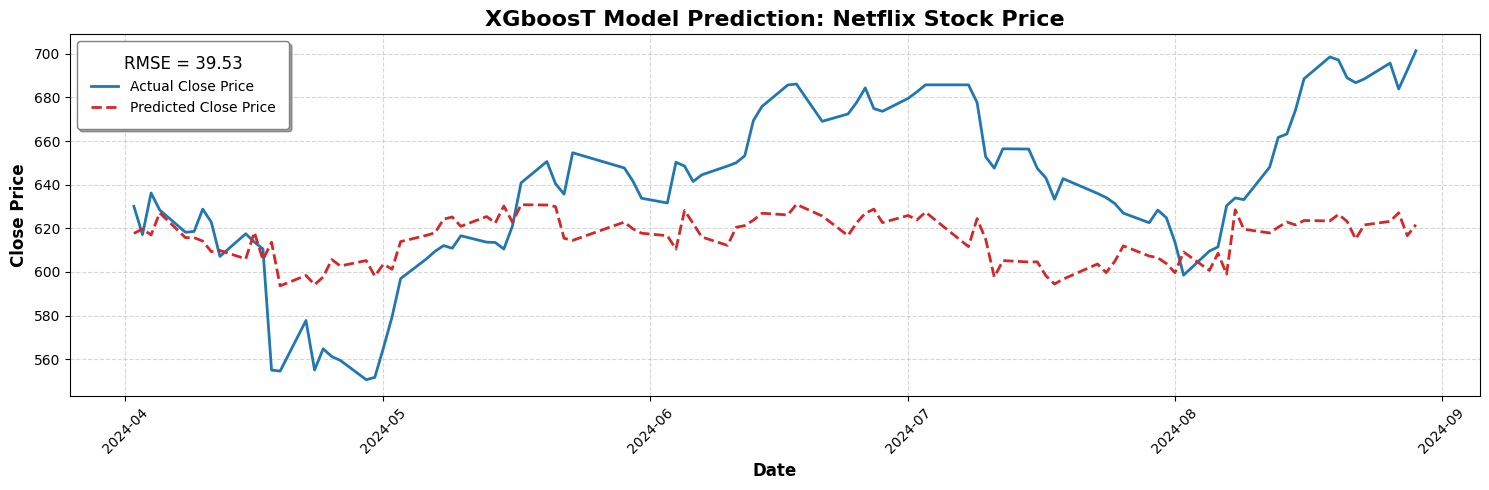

In [96]:
xg_prediction_df = merge_results(y_test, y_pred_test_xg)
plot_model_predictions(
    df=xg_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="XGboosT Model", 
    RMSE=RMSE_test_xg
)

- Summary of prediction performance of each model

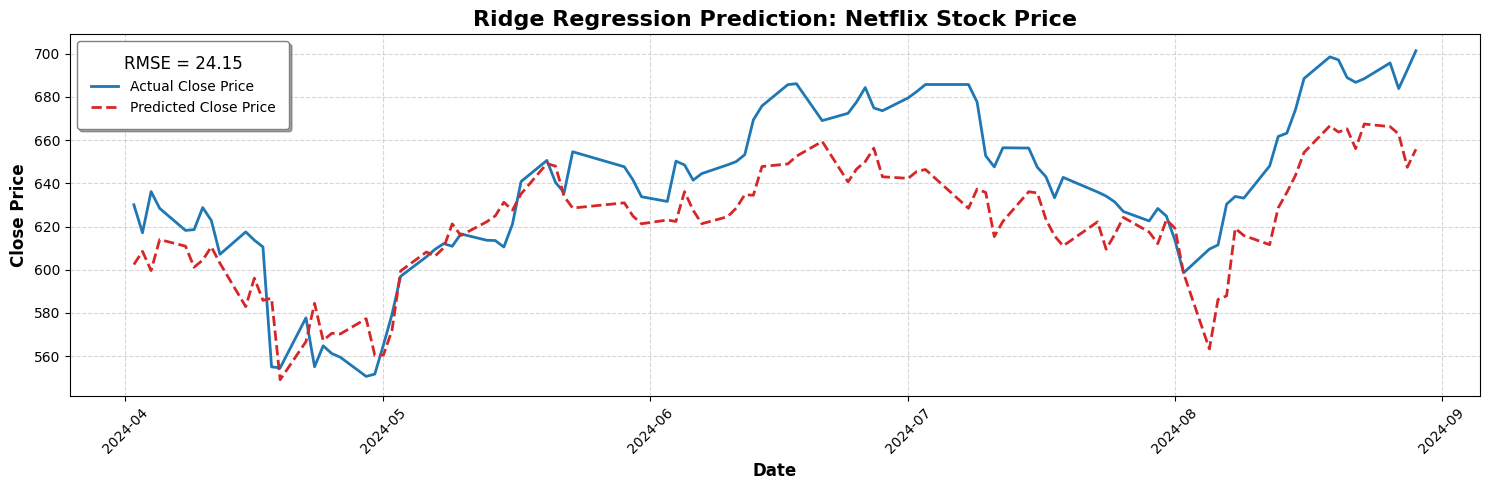

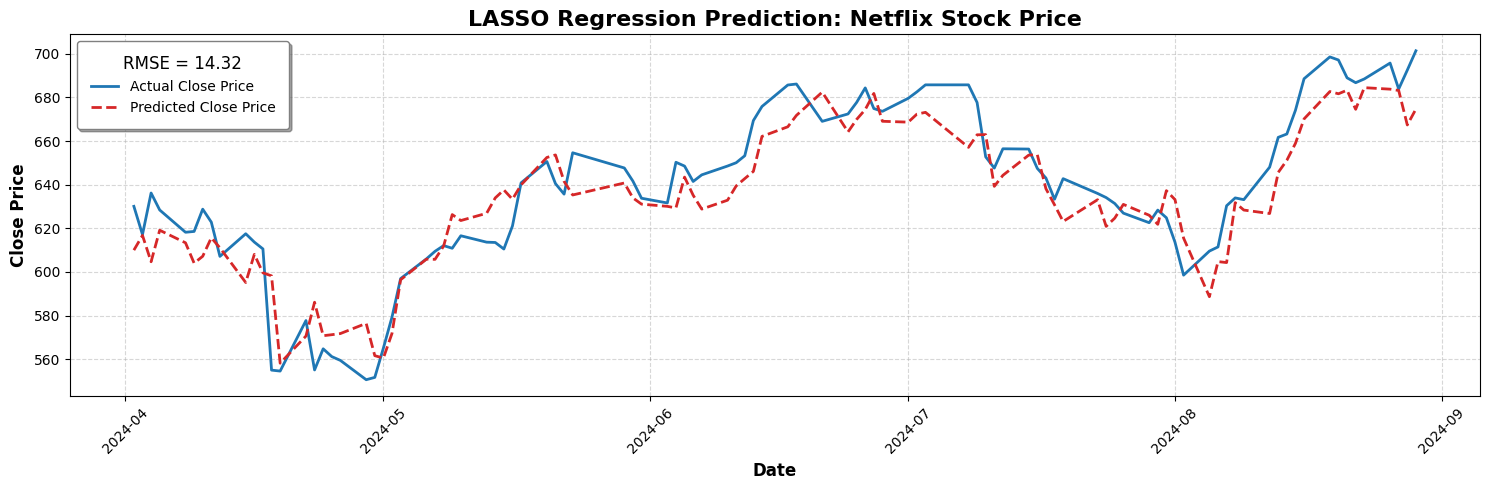

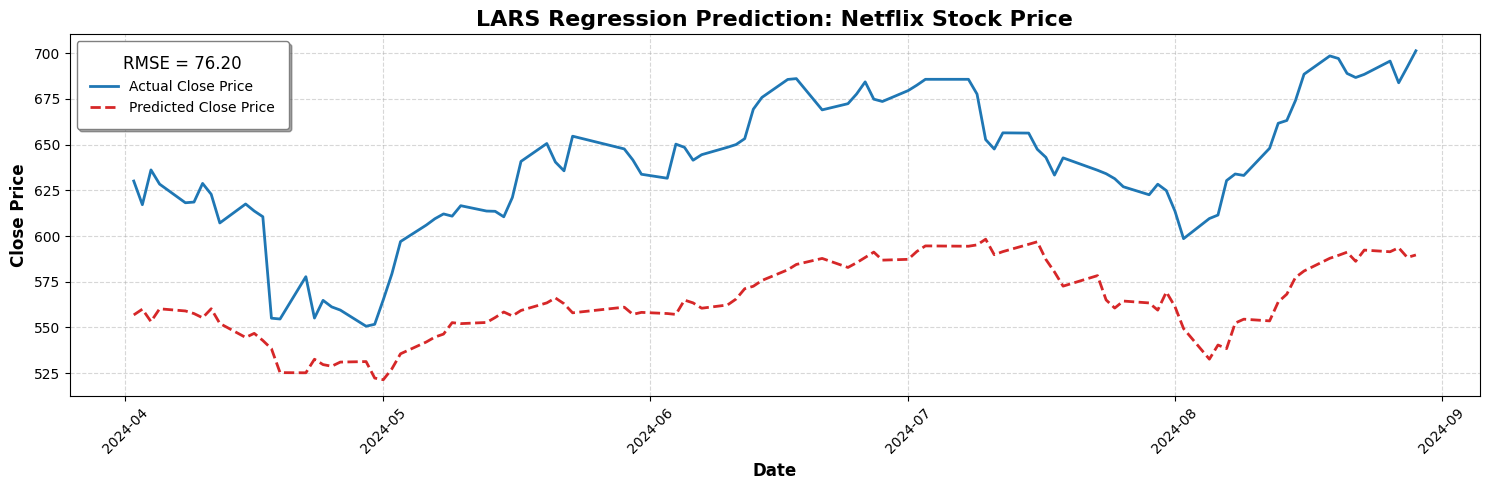

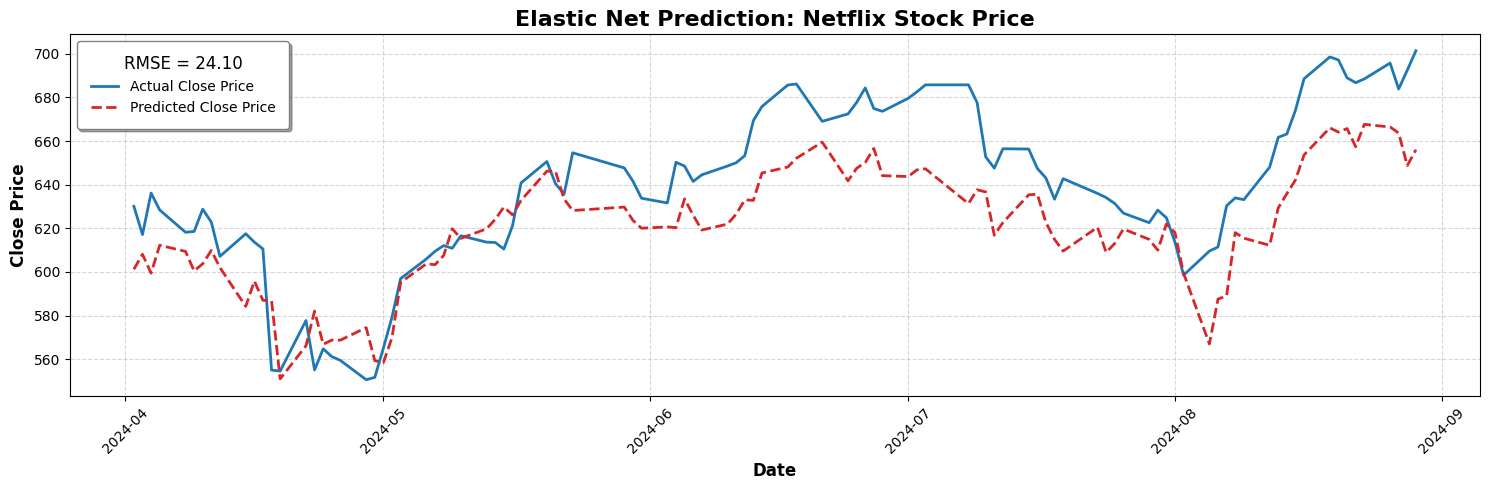

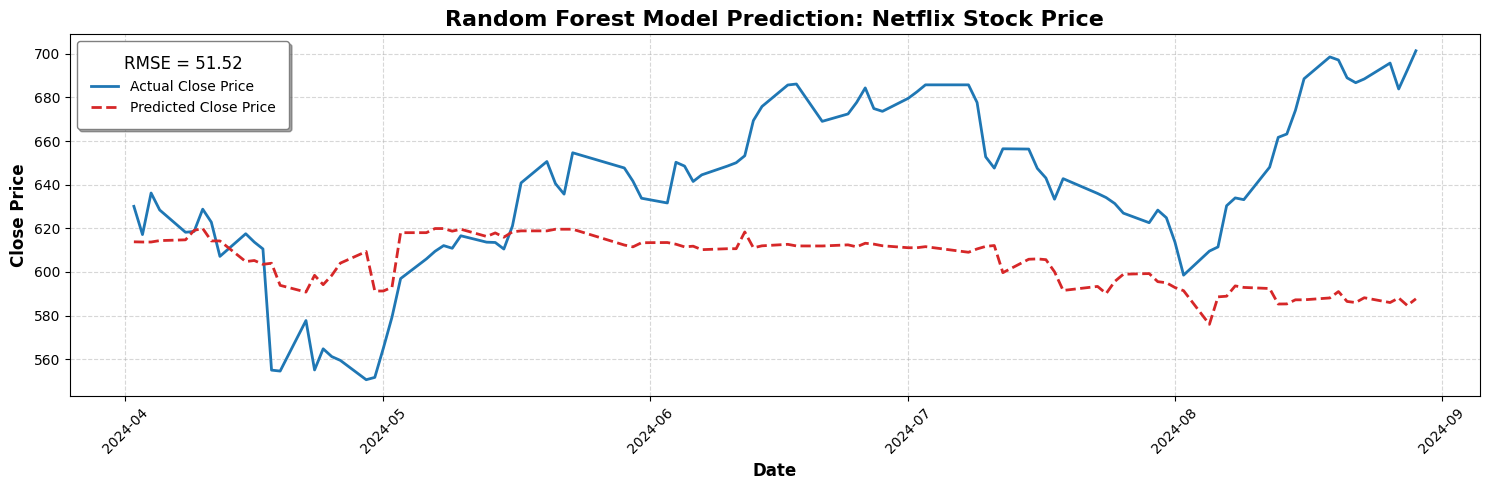

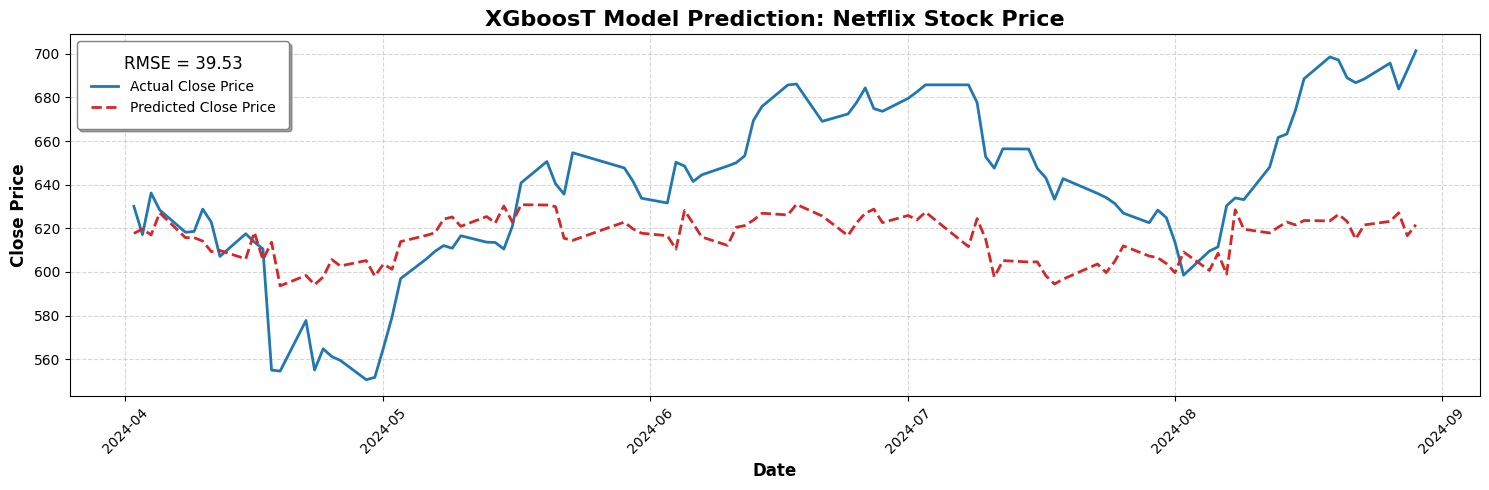

In [97]:
plot_model_predictions(
    df=ridge_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Ridge Regression", 
    RMSE=RMSE_test_ridge
)
plot_model_predictions(
    df=lasso_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="LASSO Regression", 
    RMSE=RMSE_test_lasso
)
plot_model_predictions(
    df=lars_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="LARS Regression", 
    RMSE=RMSE_test_lars
)
plot_model_predictions(
    df=en_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Elastic Net", 
    RMSE=RMSE_test_en
)
plot_model_predictions(
    df=rf_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="Random Forest Model", 
    RMSE=RMSE_test_rf
)
plot_model_predictions(
    df=xg_prediction_df, 
    actual_col='Actual Price', 
    predicted_col='Predicted Price', 
    model_name="XGboosT Model", 
    RMSE=RMSE_test_xg
)

## 3. Set trading rules, generate trading signals using the above models

- buy-and-hold

In [98]:
def buy_and_hold(result_df, initial_amount):
    amount = initial_amount
    stocks = int(amount / result_df["Actual Price"].iloc[0])
    balance = amount % result_df["Actual Price"].iloc[0]
    portfolio = stocks * result_df["Actual Price"]
    total_value = portfolio + balance

    log_df = {
        "Date": result_df.index,
        "Action": ["Buy"] + ["Hold"] * (len(result_df) - 1),
        "Portfolio Value": round(portfolio, 2),
        "Stocks Held": [stocks] * len(result_df),
        "Remaining Cash": [balance] * len(result_df),
        "Total Value": round(total_value, 2)
    }

    return pd.DataFrame(log_df).iloc[:-1].reset_index(drop=True)

- day-trade

In [99]:
def day_trade(result_df, initial_amount):
    amount = initial_amount
    balance = initial_amount
    stocks = 0
    portfolio = 0
    signal = 0
    log_df = []

    for i in range(len(result_df)-1):
        predicted_next_price = result_df["Predicted Price"].iloc[i + 1]
        actual_price = result_df["Actual Price"].iloc[i]

        if predicted_next_price > actual_price:
                if signal == 0:
                    action = "Buy"
                    stocks = int(amount / actual_price)
                    signal = 1
                    
                    balance = amount % actual_price
                    portfolio = stocks * actual_price

                    amount = portfolio + balance
                    
                else:
                    action = "Hold"
                    portfolio = stocks * actual_price
                    amount = portfolio + balance

        elif predicted_next_price < actual_price:
                if signal == 1:
                    action = "Sell"
                    stocks_sold = stocks
                    stocks = 0
                    signal = 0

                    portfolio = stocks * actual_price
                    balance += stocks_sold * actual_price
                    amount = portfolio + balance
                    
                else:
                    action = "No Action"


        log_df.append({
            "Date": result_df.index[i],
            "Actual[Current]": round(actual_price, 2),
            "Predicted[Next Day]": round(predicted_next_price, 2),
            "Action": action,
            "Portfolio Value": round(portfolio, 2),
            "Stocks Held": stocks,
            "Remaining Cash": round(balance, 2),
            "Total Value": round(amount, 2)
        })

    return pd.DataFrame(log_df)

- Visualization function for trading profit

In [100]:
def visualize_trading_strategies(day_trading_txn, buy_and_hold_txn, model_name):
    plt.figure(figsize=(15, 5))  # Slightly larger figure for better readability

    # Calculate profits for each strategy
    day_trading_profit = day_trading_txn['Total Value'].iloc[-1] - day_trading_txn['Total Value'].iloc[0]
    buy_and_hold_profit = buy_and_hold_txn['Total Value'].iloc[-1] - buy_and_hold_txn['Total Value'].iloc[0]

    # Plot Day Trading Strategy
    plt.plot(
        day_trading_txn["Date"],
        day_trading_txn["Total Value"],
        label=f"Day Trading Strategy (Profit: ${day_trading_profit:,.2f})",
        linestyle="-",
        linewidth=2,  # Thicker line for better visibility
        color="blue"  # Set color for Day Trading
    )

    # Plot Buy and Hold Strategy
    plt.plot(
        buy_and_hold_txn["Date"],
        buy_and_hold_txn["Total Value"],
        label=f"Buy and Hold Strategy (Profit: ${buy_and_hold_profit:,.2f})",
        linestyle="--",
        linewidth=2,
        color="green"
    )

    # Set dynamic title including model name
    plt.title(f"Comparison of Trading Strategies - Model: {model_name}", fontsize=18, fontweight="bold")
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Total Value ($)", fontsize=14)
    plt.legend(fontsize=13, loc="upper left", frameon=True, shadow=True)
    plt.grid(alpha=0.4, linestyle="--")
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Ensure proper layout
    plt.tight_layout()
    plt.show()


## Ridge Regerssion

In [101]:
day_trade_ridge= day_trade(ridge_prediction_df, 10000)
buy_and_hold_ridge = buy_and_hold(ridge_prediction_df, 10000)
day_trade_ridge

,Date,Actual[Current],Predicted[Next Day],Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,630.08,608.52,No Action,0.0,0,10000.00,10000.00
1,2024-04-03,617.14,599.61,No Action,0.0,0,10000.00,10000.00
2,2024-04-04,636.18,613.97,No Action,0.0,0,10000.00,10000.00
3,2024-04-05,628.41,610.91,No Action,0.0,0,10000.00,10000.00
4,2024-04-08,618.20,601.19,No Action,0.0,0,10000.00,10000.00
...,...,...,...,...,...,...,...,...
94,2024-08-22,686.73,667.45,No Action,0.0,0,11728.18,11728.18
95,2024-08-23,688.44,666.23,No Action,0.0,0,11728.18,11728.18
96,2024-08-26,695.72,662.80,No Action,0.0,0,11728.18,11728.18
97,2024-08-27,683.84,647.41,No Action,0.0,0,11728.18,11728.18


In [102]:
buy_and_hold_ridge

,Date,Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,Buy,9451.20,15,548.799744,10000.00
1,2024-04-03,Hold,9257.10,15,548.799744,9805.90
2,2024-04-04,Hold,9542.70,15,548.799744,10091.50
3,2024-04-05,Hold,9426.15,15,548.799744,9974.95
4,2024-04-08,Hold,9273.00,15,548.799744,9821.80
...,...,...,...,...,...,...
94,2024-08-22,Hold,10300.95,15,548.799744,10849.75
95,2024-08-23,Hold,10326.60,15,548.799744,10875.40
96,2024-08-26,Hold,10435.80,15,548.799744,10984.60
97,2024-08-27,Hold,10257.60,15,548.799744,10806.40


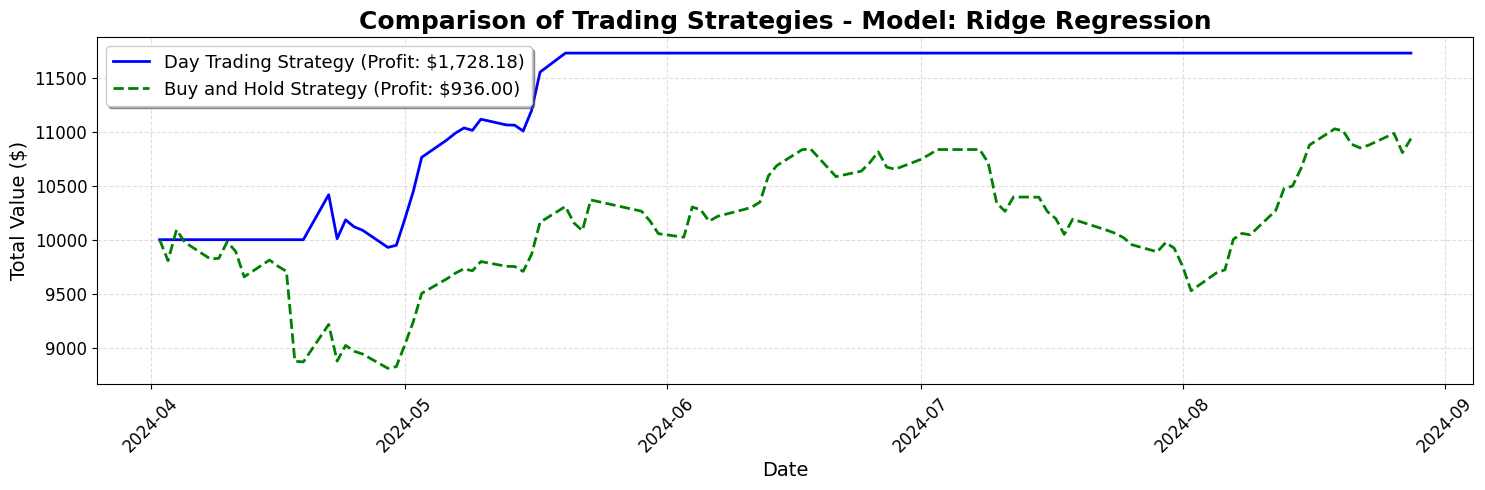

In [103]:
visualize_trading_strategies(day_trade_ridge, buy_and_hold_ridge, "Ridge Regression")

## LASSO

In [104]:
day_trade_lasso= day_trade(lasso_prediction_df, 10000)
buy_and_hold_lasso = buy_and_hold(lasso_prediction_df, 10000)
day_trade_lasso

,Date,Actual[Current],Predicted[Next Day],Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,630.08,616.76,No Action,0.0,0,10000.00,10000.00
1,2024-04-03,617.14,604.69,No Action,0.0,0,10000.00,10000.00
2,2024-04-04,636.18,619.13,No Action,0.0,0,10000.00,10000.00
3,2024-04-05,628.41,613.38,No Action,0.0,0,10000.00,10000.00
4,2024-04-08,618.20,604.04,No Action,0.0,0,10000.00,10000.00
...,...,...,...,...,...,...,...,...
94,2024-08-22,686.73,684.45,No Action,0.0,0,10887.31,10887.31
95,2024-08-23,688.44,683.76,No Action,0.0,0,10887.31,10887.31
96,2024-08-26,695.72,683.17,No Action,0.0,0,10887.31,10887.31
97,2024-08-27,683.84,667.36,No Action,0.0,0,10887.31,10887.31


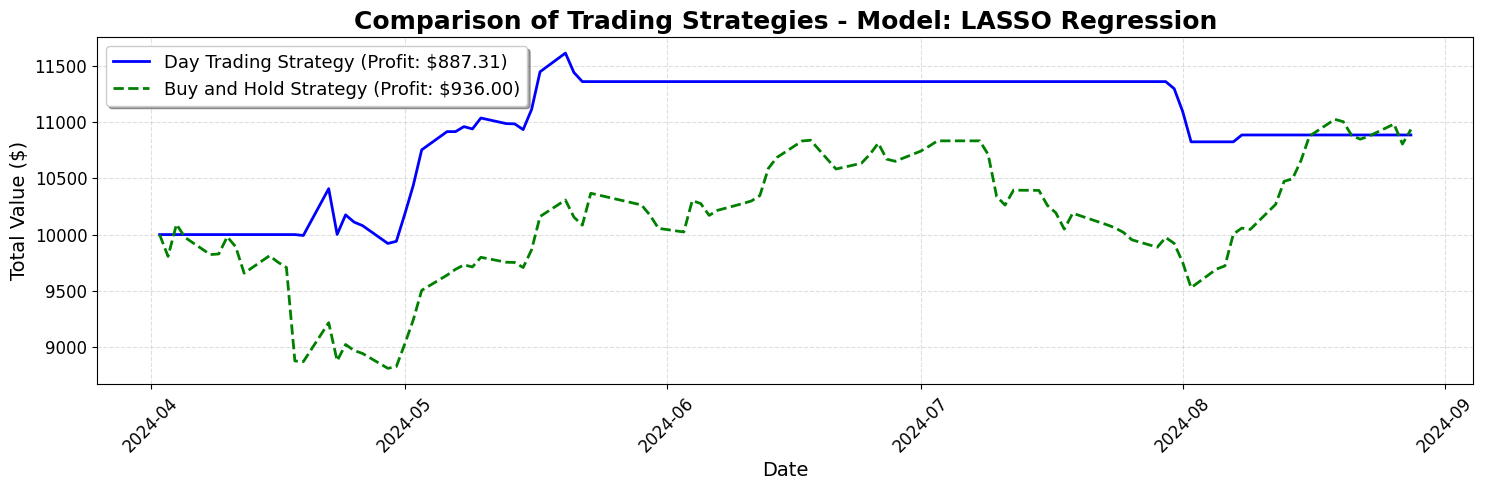

In [105]:
visualize_trading_strategies(day_trade_lasso, buy_and_hold_lasso, "LASSO Regression")

## LARS

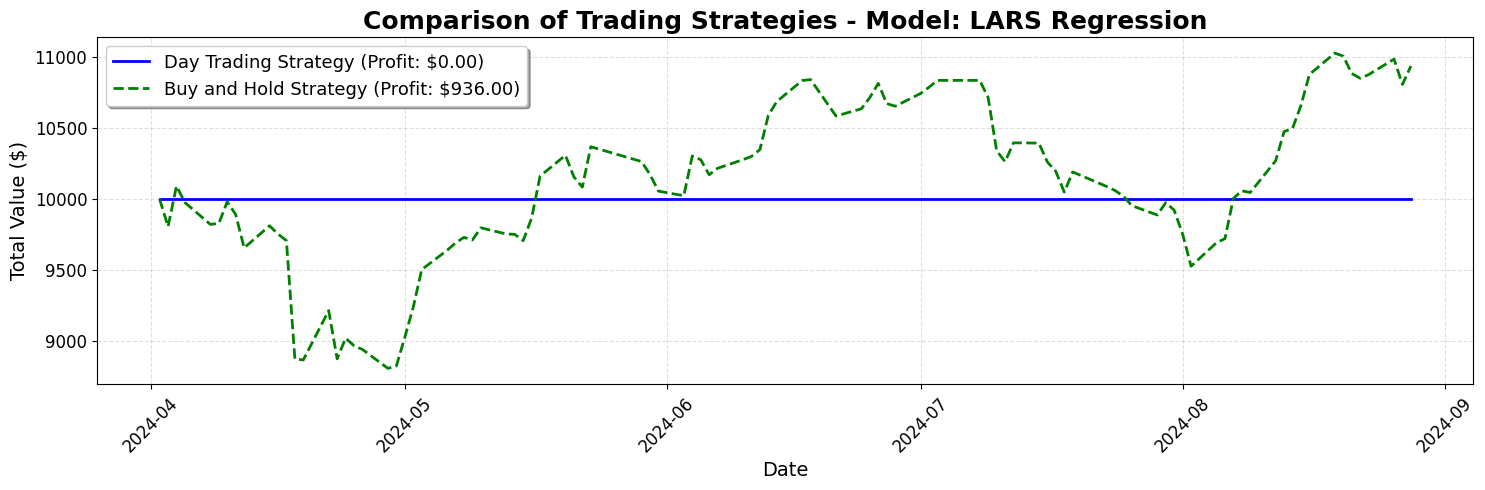

In [106]:
day_trade_lars= day_trade(lars_prediction_df, 10000)
buy_and_hold_lars = buy_and_hold(lars_prediction_df, 10000)
visualize_trading_strategies(day_trade_lars, buy_and_hold_lars, "LARS Regression")

## Elastic Net

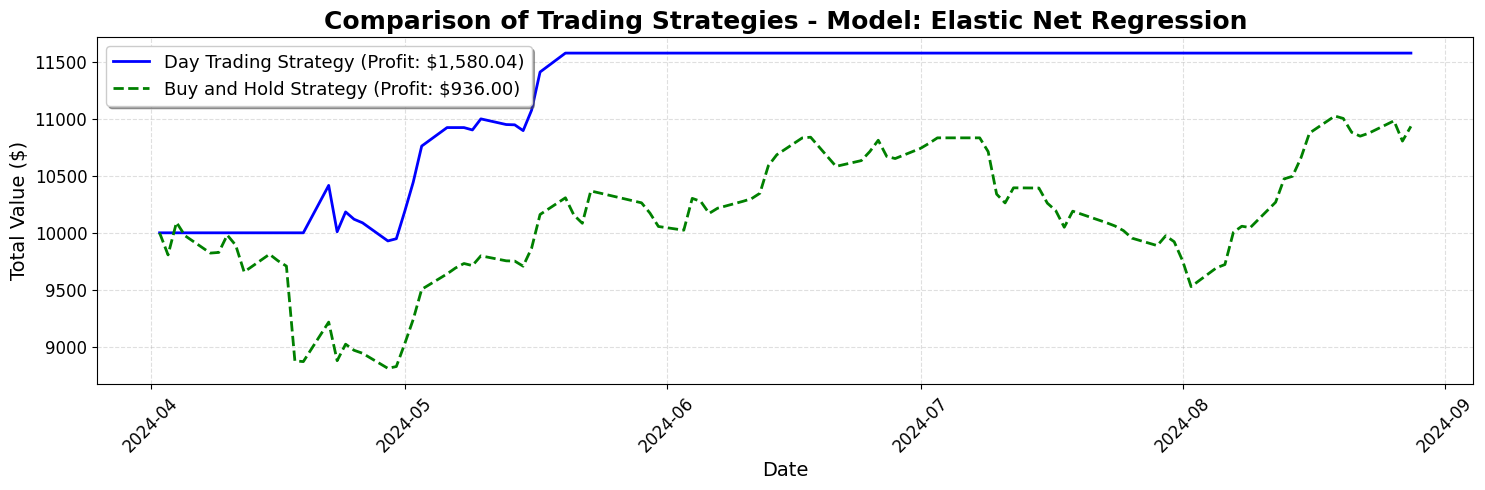

In [113]:
day_trade_en= day_trade(en_prediction_df, 10000)
buy_and_hold_en = buy_and_hold(en_prediction_df, 10000)
visualize_trading_strategies(day_trade_en, buy_and_hold_en, "Elastic Net Regression")

In [108]:
day_trade_en

,Date,Actual[Current],Predicted[Next Day],Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,630.08,608.11,No Action,0.0,0,10000.00,10000.00
1,2024-04-03,617.14,599.46,No Action,0.0,0,10000.00,10000.00
2,2024-04-04,636.18,612.24,No Action,0.0,0,10000.00,10000.00
3,2024-04-05,628.41,609.44,No Action,0.0,0,10000.00,10000.00
4,2024-04-08,618.20,600.49,No Action,0.0,0,10000.00,10000.00
...,...,...,...,...,...,...,...,...
94,2024-08-22,686.73,667.63,No Action,0.0,0,11580.04,11580.04
95,2024-08-23,688.44,666.43,No Action,0.0,0,11580.04,11580.04
96,2024-08-26,695.72,663.65,No Action,0.0,0,11580.04,11580.04
97,2024-08-27,683.84,648.76,No Action,0.0,0,11580.04,11580.04


## Random Forest

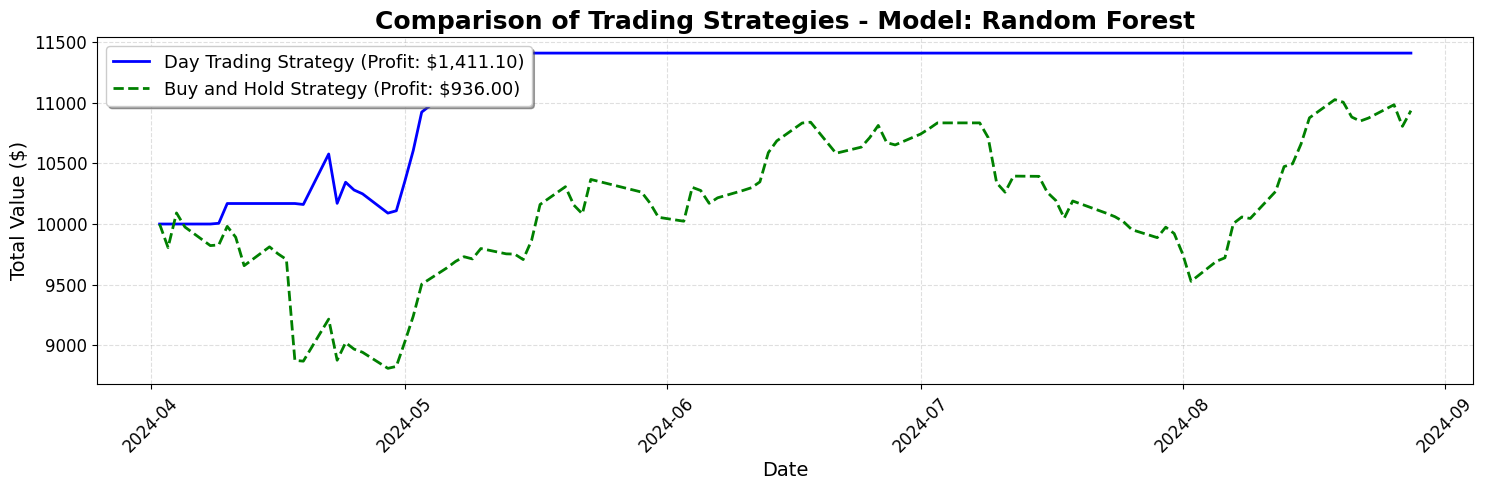

In [109]:
day_trade_rf= day_trade(rf_prediction_df, 10000)
buy_and_hold_rf = buy_and_hold(rf_prediction_df, 10000)
day_trade_rf
visualize_trading_strategies(day_trade_rf, buy_and_hold_rf, "Random Forest")

In [110]:
day_trade_rf

,Date,Actual[Current],Predicted[Next Day],Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,630.08,613.73,No Action,0.0,0,10000.0,10000.0
1,2024-04-03,617.14,613.73,No Action,0.0,0,10000.0,10000.0
2,2024-04-04,636.18,614.38,No Action,0.0,0,10000.0,10000.0
3,2024-04-05,628.41,614.73,No Action,0.0,0,10000.0,10000.0
4,2024-04-08,618.20,619.06,Buy,9891.2,16,108.8,10000.0
...,...,...,...,...,...,...,...,...
94,2024-08-22,686.73,588.20,No Action,0.0,0,11411.1,11411.1
95,2024-08-23,688.44,586.00,No Action,0.0,0,11411.1,11411.1
96,2024-08-26,695.72,588.11,No Action,0.0,0,11411.1,11411.1
97,2024-08-27,683.84,584.65,No Action,0.0,0,11411.1,11411.1


## XGboost

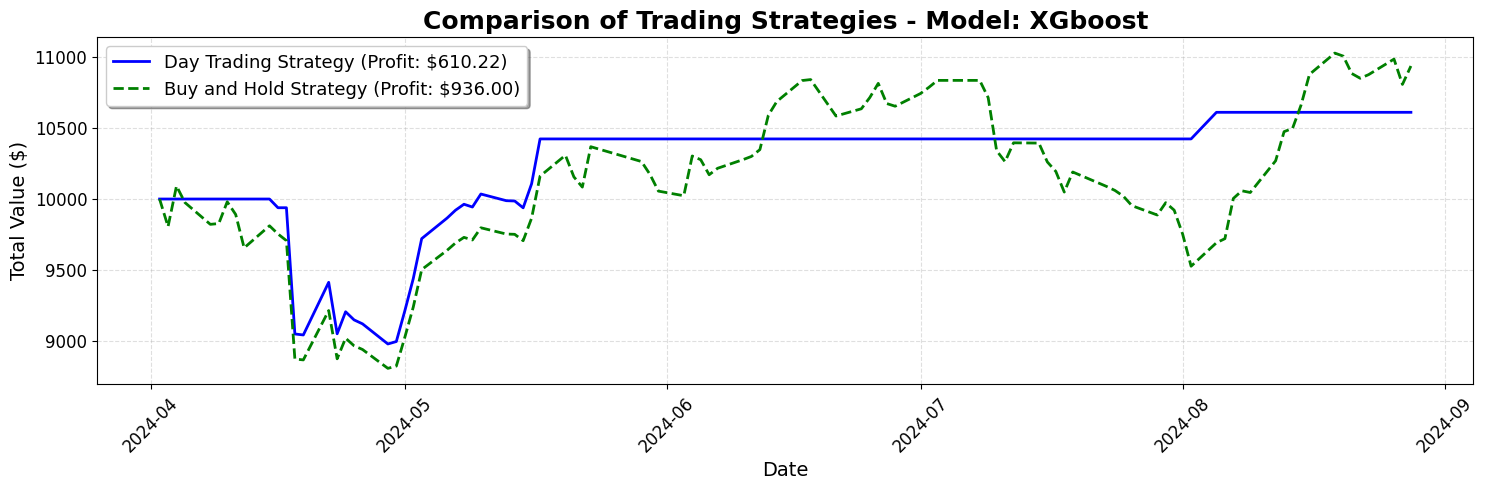

In [111]:
day_trade_xg= day_trade(xg_prediction_df, 10000)
buy_and_hold_xg = buy_and_hold(xg_prediction_df, 10000)
visualize_trading_strategies(day_trade_xg, buy_and_hold_xg, "XGboost")

In [112]:
day_trade_xg

,Date,Actual[Current],Predicted[Next Day],Action,Portfolio Value,Stocks Held,Remaining Cash,Total Value
0,2024-04-02,630.08,619.710022,No Action,0.0,0,10000.00,10000.00
1,2024-04-03,617.14,616.969971,No Action,0.0,0,10000.00,10000.00
2,2024-04-04,636.18,627.099976,No Action,0.0,0,10000.00,10000.00
3,2024-04-05,628.41,615.729980,No Action,0.0,0,10000.00,10000.00
4,2024-04-08,618.20,615.719971,No Action,0.0,0,10000.00,10000.00
...,...,...,...,...,...,...,...,...
94,2024-08-22,686.73,621.570007,No Action,0.0,0,10610.22,10610.22
95,2024-08-23,688.44,623.179993,No Action,0.0,0,10610.22,10610.22
96,2024-08-26,695.72,627.119995,No Action,0.0,0,10610.22,10610.22
97,2024-08-27,683.84,616.619995,No Action,0.0,0,10610.22,10610.22
